In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from itertools import chain
from collections import defaultdict
import math
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, f1_score, roc_auc_score
import graphviz 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# personal modules
import ml_pipeline_lch as ml
import ml_explore as exp
import ml_modeling as md
import magiclooping as mp

sns.set(style = "ticks", color_codes = True)
%matplotlib inline 

### Read and Pre-Process Data

#### Read Data

In [2]:
outcomes_df = ml.retrieve_data(filename = 'data/outcomes.csv', headers = True, set_ind = 0)

In [3]:
outcomes_df.head()

,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
projectid,,,,,,,,,,,
ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0


In [4]:
projects_df = ml.retrieve_data(filename = 'data/projects.csv', headers = True, set_ind = 0)

In [5]:
project_info = pd.merge(projects_df, pd.DataFrame(outcomes_df['fully_funded']), how = 'inner', right_index = True, left_index = True)

In [6]:
project_info.fully_funded.dtype

dtype('O')

In [7]:
project_info.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,t
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,f
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,f
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,f
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,t


### Date Transformation and Narrowing

#### Period Transformation

In [8]:
project_info['date_posted'] = ml.convert_dates(project_info['date_posted'])

In [9]:
project_info['year'] = project_info['date_posted'].apply(lambda x: x.year)

In [10]:
project_info['month'] = project_info['date_posted'].apply(lambda x: x.month)

In [11]:
project_info['year'].unique()

array([2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003,
       2002])

In [12]:
project_info = project_info[(project_info['date_posted'] >= datetime.strptime('2011-01-01', '%Y-%m-%d')) & (project_info['date_posted'] <= datetime.strptime('2013-12-31', '%Y-%m-%d'))]            
                                     

In [13]:
project_info['year'].unique()

array([2013, 2012, 2011])

### Column Details Exploration

In [14]:
project_info.describe().round(3).transpose()

,count,mean,std,min,25%,50%,75%,max
school_ncesid,328293.0,2.503127e+11,1.648173e+11,1.000050e+10,6.372301e+10,2.400090e+11,3.904440e+11,6.100008e+11
school_latitude,353151.0,3.686900e+01,4.927000e+00,1.824900e+01,3.391600e+01,3.667600e+01,4.068000e+01,6.725800e+01
school_longitude,353151.0,-9.539800e+01,1.811800e+01,-1.716910e+02,-1.172470e+02,-8.988600e+01,-8.076200e+01,-6.662800e+01
school_zip,353151.0,5.630176e+04,3.104352e+04,4.100000e+02,2.938800e+04,6.061300e+04,9.000700e+04,9.992600e+04
fulfillment_labor_materials,353151.0,3.222000e+01,2.484000e+00,3.000000e+01,3.000000e+01,3.000000e+01,3.500000e+01,3.500000e+01
total_price_excluding_optional_support,353151.0,5.313720e+02,8.440690e+02,3.703000e+01,2.887500e+02,4.272700e+02,6.067200e+02,1.397254e+05
total_price_including_optional_support,353151.0,6.251440e+02,9.930230e+02,4.356000e+01,3.397100e+02,5.026700e+02,7.137900e+02,1.643828e+05
students_reached,353050.0,9.418700e+01,1.569870e+02,1.000000e+00,2.300000e+01,3.100000e+01,1.000000e+02,1.214300e+04
year,353151.0,2.012077e+03,8.130000e-01,2.011000e+03,2.011000e+03,2.012000e+03,2.013000e+03,2.013000e+03
month,353151.0,6.933000e+00,3.591000e+00,1.000000e+00,3.000000e+00,8.000000e+00,1.000000e+01,1.200000e+01


In [15]:
summary_df, types = ml.summarize_df(project_info)

Starting next train-test set...


In [16]:
summary_df.sort_values(by='col_type')

,num_values,num_nulls,unique_values,data_type,col_type,most_common
col_name,,,,,,
teacher_acctid,353151,0,157144,object,ID,214acf23d183dfa2f1dc16e7b3658320
schoolid,353151,0,44833,object,ID,9943fdb43ab5f2b53f27e961caf9e90a
school_ncesid,353151,24858,41107,float64,ID,3.60015e+11
fully_funded,353151,0,2,object,binary,t
eligible_almost_home_match,353151,0,2,object,binary,f
eligible_double_your_impact_match,353151,0,2,object,binary,f
teacher_ny_teaching_fellow,353151,0,2,object,binary,f
school_charter_ready_promise,353151,0,2,object,binary,f
school_kipp,353151,0,2,object,binary,f


In [17]:
types

defaultdict(list,
            {'ID': ['teacher_acctid', 'schoolid', 'school_ncesid'],
             'geo': ['school_latitude',
              'school_longitude',
              'school_city',
              'school_state',
              'school_zip',
              'school_county'],
             'multi': ['school_metro',
              'teacher_prefix',
              'poverty_level',
              'grade_level'],
             'tops': ['school_district',
              'primary_focus_subject',
              'primary_focus_area',
              'secondary_focus_subject',
              'secondary_focus_area',
              'resource_type'],
             'binary': ['school_charter',
              'school_magnet',
              'school_year_round',
              'school_nlns',
              'school_kipp',
              'school_charter_ready_promise',
              'teacher_teach_for_america',
              'teacher_ny_teaching_fellow',
              'eligible_double_your_impact_match',
            

In [18]:
types = ml.recateogrize_col('school_county', 'tops', types)

In [19]:
types = ml.recateogrize_col('school_state', 'tops', types)

In [20]:
types = ml.recateogrize_col('school_city', 'tops', types)

In [21]:
types

defaultdict(list,
            {'ID': ['teacher_acctid', 'schoolid', 'school_ncesid'],
             'geo': ['school_latitude', 'school_longitude', 'school_zip'],
             'multi': ['school_metro',
              'teacher_prefix',
              'poverty_level',
              'grade_level'],
             'tops': ['school_district',
              'primary_focus_subject',
              'primary_focus_area',
              'secondary_focus_subject',
              'secondary_focus_area',
              'resource_type',
              'school_county',
              'school_state',
              'school_city'],
             'binary': ['school_charter',
              'school_magnet',
              'school_year_round',
              'school_nlns',
              'school_kipp',
              'school_charter_ready_promise',
              'teacher_teach_for_america',
              'teacher_ny_teaching_fellow',
              'eligible_double_your_impact_match',
              'eligible_almost_home_matc

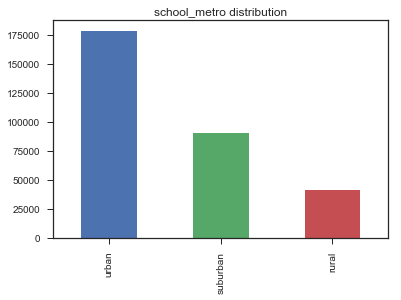

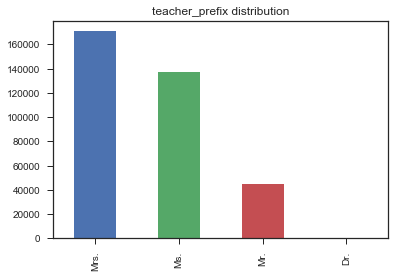

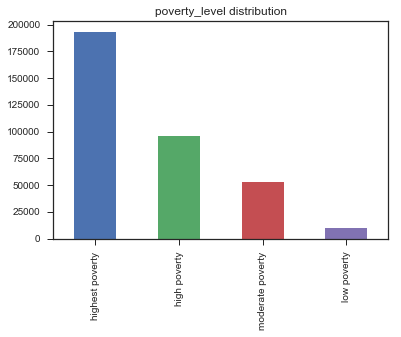

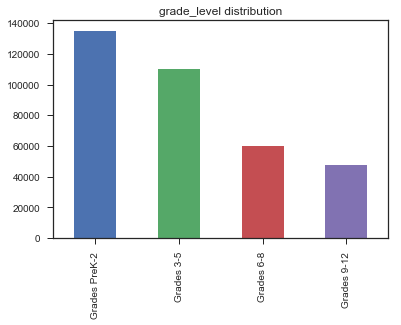

In [22]:
exp.plot_value_counts(project_info, types, 'multi')

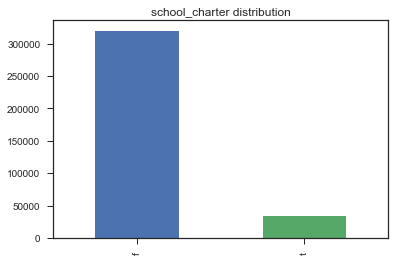

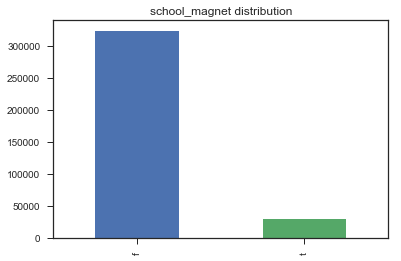

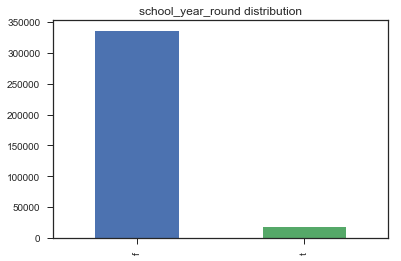

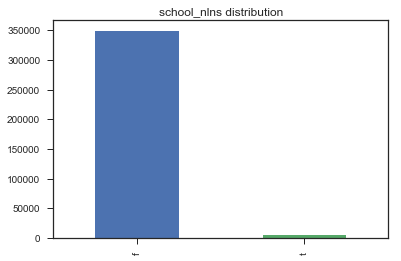

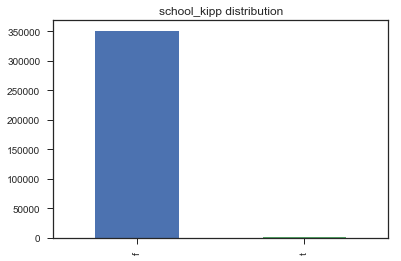

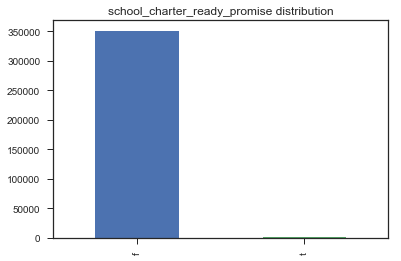

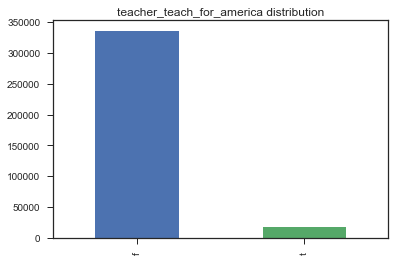

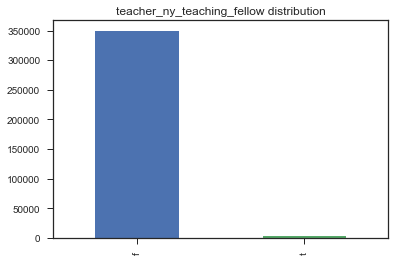

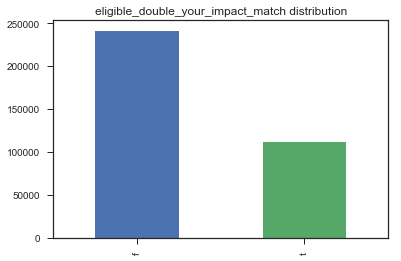

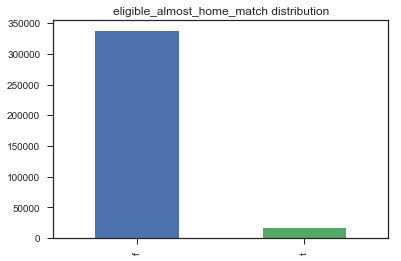

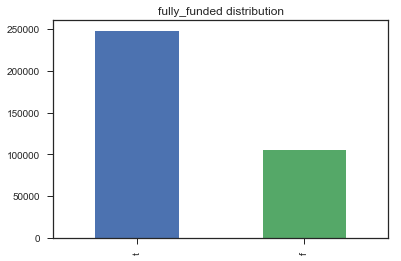

In [23]:
exp.plot_value_counts(project_info, types, 'binary')

### Outlier Evaluation

In [24]:
maxes = ml.view_max_mins(project_info, max = True)
maxes.tail().round(2)

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.996,5.509600e+11,48.05,-70.29,98952.0,35.0,3930.71,4624.36,999.0,2013.0,12.0
0.997,5.512330e+11,48.87,-70.23,99343.0,35.0,4810.63,5659.56,999.0,2013.0,12.0
0.998,5.514750e+11,61.19,-69.97,99507.0,35.0,6136.87,7219.85,999.0,2013.0,12.0
0.999,5.516830e+11,61.22,-69.11,99577.0,35.0,8699.96,10235.25,999.0,2013.0,12.0
1.000,6.100008e+11,67.26,-66.63,99926.0,35.0,139725.41,164382.84,12143.0,2013.0,12.0


In [25]:
likely_outliers_upper = ml.view_likely_outliers(project_info)
likely_outliers_upper.tail()

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.996,2.666241e-09,0.005071,-0.006003,0.002716,0.0,0.185147,0.185147,0.000000,0.0,0.0
0.997,4.954968e-04,0.016860,-0.000961,0.003951,0.0,0.223858,0.223859,0.000000,0.0,0.0
0.998,4.390019e-04,0.252270,-0.003614,0.001651,0.0,0.275690,0.275690,0.000000,0.0,0.0
0.999,3.771853e-04,0.000442,-0.012383,0.000703,0.0,0.417654,0.417654,0.000000,0.0,0.0
1.000,1.057089e-01,0.098641,-0.035873,0.003505,0.0,15.060468,15.060462,11.155155,0.0,0.0


In [26]:
mins = ml.view_max_mins(project_info, max = False)
mins

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.000,1.000050e+10,18.249140,-171.690554,410.0,30.0,37.0300,43.5600,1.0,2011.0,1.0
0.001,1.002700e+10,20.864705,-158.192448,1118.0,30.0,132.8400,156.2800,2.0,2011.0,1.0
0.002,1.010200e+10,21.344914,-158.012455,1602.0,30.0,134.3330,158.0430,3.0,2011.0,1.0
0.003,1.017400e+10,21.384429,-157.871713,1610.0,30.0,135.9900,159.9900,4.0,2011.0,1.0
0.004,1.020400e+10,21.512068,-157.728836,1840.0,30.0,137.1900,161.4000,5.0,2011.0,1.0
0.005,1.023700e+10,25.397676,-155.096330,1852.0,30.0,138.4200,162.8500,5.0,2011.0,1.0
0.006,1.026500e+10,25.599142,-149.808700,2026.0,30.0,139.3900,163.9900,6.0,2011.0,1.0
0.007,1.029113e+10,25.699131,-149.720276,2119.0,30.0,140.1205,164.8505,6.0,2011.0,1.0
0.008,1.033900e+10,25.743486,-124.206627,2122.0,30.0,140.8900,165.7500,6.0,2011.0,1.0
0.009,2.001800e+10,25.777018,-123.725756,2127.0,30.0,141.5500,166.5300,6.0,2011.0,1.0


In [27]:
likely_outliers_lower = ml.view_likely_outliers(project_info, max = False)
likely_outliers_lower

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,2.649951e-03,0.143325,-0.078619,1.726829,0.0,2.587362,2.587695,1.000000,0.0,0.0
0.002,7.479675e-03,0.023015,-0.001138,0.432916,0.0,0.011239,0.011281,0.500000,0.0,0.0
0.003,7.127319e-03,0.001851,-0.000891,0.004994,0.0,0.012335,0.012319,0.333333,0.0,0.0
0.004,2.948710e-03,0.005969,-0.000905,0.142857,0.0,0.008824,0.008813,0.250000,0.0,0.0
0.005,3.234090e-03,0.180625,-0.016690,0.006522,0.0,0.008966,0.008984,0.000000,0.0,0.0
0.006,2.735179e-03,0.007932,-0.034093,0.093952,0.0,0.007008,0.007000,0.200000,0.0,0.0
0.007,2.545706e-03,0.003906,-0.000590,0.045903,0.0,0.005241,0.005247,0.000000,0.0,0.0
0.008,4.651396e-03,0.001726,-0.170409,0.001416,0.0,0.005492,0.005456,0.000000,0.0,0.0
0.009,9.361638e-01,0.001303,-0.003872,0.002356,0.0,0.004685,0.004706,0.000000,0.0,0.0


#### Create copy of dataframe to manipulate and explore

In [28]:
# copy dataframe
manip_df = project_info[list(project_info.columns)]

In [29]:
# view copy
manip_df.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded,year,month
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,30.0,444.36,522.78,7.0,f,f,2013-12-31,t,2013,12
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,30.0,233.24,274.40,30.0,f,f,2013-12-31,f,2013,12
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,30.0,285.09,335.40,230.0,f,f,2013-12-31,f,2013,12
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,30.0,232.94,274.05,18.0,f,f,2013-12-31,f,2013,12
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,30.0,513.41,604.01,70.0,t,f,2013-12-31,t,2013,12


#### Drop Unwanted Columns

In [30]:
types['geo']

['school_latitude', 'school_longitude', 'school_zip']

In [31]:
types['ID']

['teacher_acctid', 'schoolid', 'school_ncesid']

In [32]:
all_drops = types['ID'] + types['geo']

In [33]:
ml.drop_unwanted(manip_df, all_drops)

#### Outlier Removal

In [34]:
# total price and students reached values should not be inf 
ml.remove_over_under_threshold(manip_df, col = 'total_price_excluding_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'total_price_including_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'students_reached', min_val = 0, max_val = False, lwr_threshold = 0.005, upr_threshold = False)


In [35]:
# check that expected values were removed
likely_outliers_lower_post = ml.view_likely_outliers(manip_df, max = False)
likely_outliers_lower_post

,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.000,NaN,NaN,NaN,NaN,NaN,NaN
0.001,0.0,0.011051,0.011057,0.000000,0.0,0.0
0.002,0.0,0.012375,0.012354,0.000000,0.0,0.0
0.003,0.0,0.008899,0.008940,0.200000,0.0,0.0
0.004,0.0,0.008966,0.008984,0.000000,0.0,0.0
0.005,0.0,0.007008,0.007001,0.000000,0.0,0.0
0.006,0.0,0.005237,0.005245,0.000000,0.0,0.0
0.007,0.0,0.005567,0.005521,0.166667,0.0,0.0
0.008,0.0,0.004614,0.004646,0.000000,0.0,0.0
0.009,0.0,0.004027,0.004024,0.000000,0.0,0.0


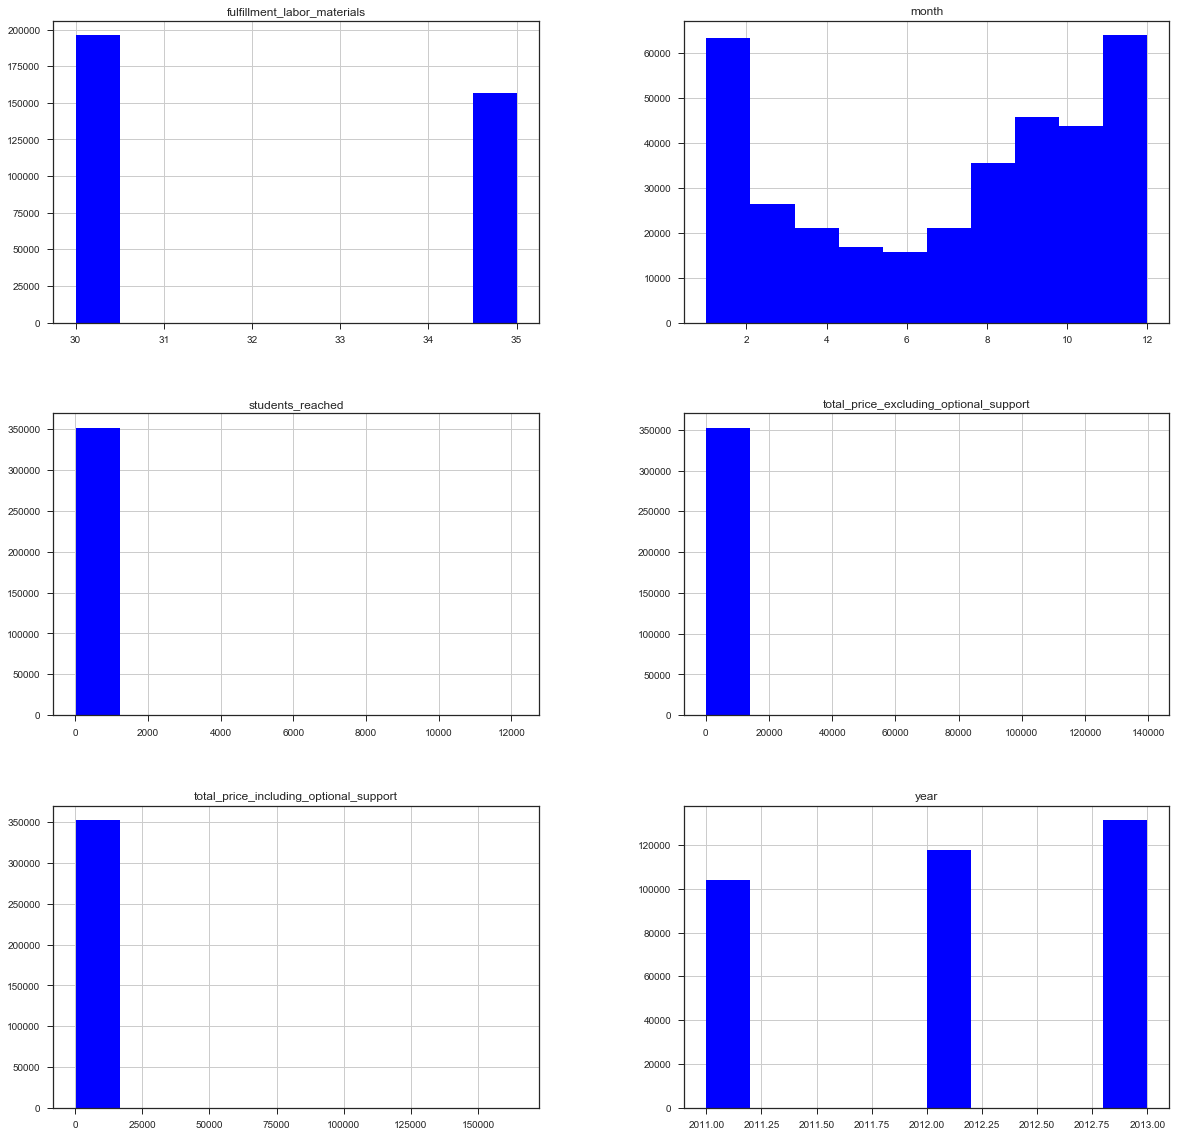

In [36]:
exp.view_dist(manip_df, geo_columns= True,fig_size = (20, 20))

In [37]:
# for col in types['numeric']:
# #     x = manip_df[col].apply(lambda x: np.log(x) if x != 0 else 0)
#     sns.distplot(x.dropna())

### Feature Generation

#### Binary Conversion

In [38]:
types['binary']

['school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'fully_funded']

In [39]:
# convert binary values
ml.make_boolean(manip_df, types['binary'], value_1s = 't')

In [40]:
# confirm change
manip_df.school_charter.unique()

array([0, 1])

In [41]:
print(manip_df.columns)
print(len(manip_df.columns))

Index(['school_city', 'school_state', 'school_metro', 'school_district',
       'school_county', 'school_charter', 'school_magnet', 'school_year_round',
       'school_nlns', 'school_kipp', 'school_charter_ready_promise',
       'teacher_prefix', 'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'fulfillment_labor_materials', 'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'fully_funded', 'year', 'month'],
      dtype='object')
31


#### Dummy variable creation - Multi-value columns

In [42]:
types['multi']

['school_metro', 'teacher_prefix', 'poverty_level', 'grade_level']

In [43]:
# convert multi-value columns to binary dummy variables
# manip_df = ml.replace_dummies(manip_df, types['multi'])

In [44]:
# # confirm columns were created
# ml.check_col_types(manip_df)

In [45]:
# for col in manip_df:
#     if manip_df[col].dtype == 'uint8':
#         manip_df[col] = manip_df[col].astype('int')

### Split Train and Test Sets

In [46]:
(all_sets, date_ref) = ml.create_expanding_splits(manip_df, 
                                      total_periods = 36, 
                                      dates = 'date_posted', 
                                      train_period_base = 12, 
                                      test_period_size = 3, 
                                      period = 'month', 
                                      defined_start = '2011-01-01')


original train period lenth: 12
train: (104547, 31), test: (36917, 31)
original train period lenth: 15
train: (141318, 31), test: (15640, 31)
original train period lenth: 18
train: (156824, 31), test: (31978, 31)
original train period lenth: 21
train: (188309, 31), test: (33947, 31)
original train period lenth: 24
train: (222062, 31), test: (24079, 31)
original train period lenth: 27
train: (245843, 31), test: (19454, 31)
original train period lenth: 30
train: (265235, 31), test: (44368, 31)
original train period lenth: 33
train: (309067, 31), test: (44084, 31)


In [47]:
date_ref

,training_start,training_period_end,test_period_start,test_period_end
0,2011-01-01,2012-01-01,2012-01-02,2012-04-02
1,2011-01-01,2012-04-01,2012-04-02,2012-07-02
2,2011-01-01,2012-07-01,2012-07-02,2012-10-02
3,2011-01-01,2012-10-01,2012-10-02,2013-01-02
4,2011-01-01,2013-01-01,2013-01-02,2013-04-02
5,2011-01-01,2013-04-01,2013-04-02,2013-07-02
6,2011-01-01,2013-07-01,2013-07-02,2013-10-02
7,2011-01-01,2013-10-01,2013-10-02,2013-12-31


### Create training-set-specific dummy variables

In [48]:
fg_sets = [ml.iza_process(train, test, types, tops_threshold = 0.5, binary = None) for (train, test) in all_sets]



Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric c

In [49]:
for train, test in fg_sets:
    print(train.shape)
    print(test.shape)
    print()

(104547, 104)
(36917, 104)

(141318, 104)
(15640, 104)

(156824, 104)
(31978, 104)

(188309, 104)
(33947, 104)

(222062, 104)
(24079, 104)

(245843, 104)
(19454, 104)

(265235, 104)
(44368, 104)

(309067, 104)
(44084, 104)



In [50]:
ml.check_col_types(fg_sets[0][1])

,data_type
school_charter,int64
school_magnet,int64
school_year_round,int64
school_nlns,int64
school_kipp,int64
school_charter_ready_promise,int64
teacher_teach_for_america,int64
teacher_ny_teaching_fellow,int64
fulfillment_labor_materials,float64
total_price_excluding_optional_support,float64


In [50]:
# exp.plot_top_distros(all_sets, type_dict, set_num = 7)

#### Address missing values in numeric columns

In [51]:
# remaining_blanks = ml.still_blank(fg_sets)

In [53]:
# exp.discretize_train_test(fg_sets, remaining_blanks)

In [54]:
# exp.confirm_train_test_discretization(fg_sets, remaining_blanks)

In [55]:
# fg_sets = ml.dummies_tt_timeporal(all_sets, replace = ['students_reached_bin', 'total_price_excluding_optional_support_bin', 'total_price_including_optional_support_bin'])

In [56]:
# exp.drop_tt_binned(fg_sets, type_dict['numeric'])

In [51]:
def temporal_train_test_split(df, outcome_var, exclude = [], subset_cols = False):
    if not subset_cols:
        skips = [outcome_var] + exclude
        Xs = df.drop(skips, axis = 1)
    else:
        Xs = df[subset_cols]
    
    Ys = df[outcome_var]

    return Xs, Ys

In [54]:
def run_models(train_test_tuples, outcome_var):
    for i, (train, test) in enumerate(train_test_tuples):
        all_results = []
        print("set", i)

        x_train, y_train = temporal_train_test_split(train, outcome_var)
        x_test, y_test = temporal_train_test_split(test, outcome_var)
        results = md.cf_loop(x_train, y_train, x_test, y_test, 
                             ks = [1, 2, 5, 10, 20, 30, 50], 
                             set_num = i, params_dict = None, 
                             which_clfs = ("LogisticRegression", "KNN", "AdaBoost", 
                                           "NaiveBayes", "Decision Tree", "Bagging"))
        all_results.append(results)

    return pd.concat(all_results, ignore_index = True)


In [55]:
date_ref

,training_start,training_period_end,test_period_start,test_period_end
0,2011-01-01,2012-01-01,2012-01-02,2012-04-02
1,2011-01-01,2012-04-01,2012-04-02,2012-07-02
2,2011-01-01,2012-07-01,2012-07-02,2012-10-02
3,2011-01-01,2012-10-01,2012-10-02,2013-01-02
4,2011-01-01,2013-01-01,2013-01-02,2013-04-02
5,2011-01-01,2013-04-01,2013-04-02,2013-07-02
6,2011-01-01,2013-07-01,2013-07-02,2013-10-02
7,2011-01-01,2013-10-01,2013-10-02,2013-12-31


In [ ]:
tessss = run_models(fg_sets, 'fully_funded')

set 0
Creating classifier: LogisticRegression
Creating args for: LogisticRegression models
Evaluating LogisticRegression models
Creating classifier: KNN
Creating args for: KNN models
Evaluating KNN models
Creating classifier: AdaBoost
Creating args for: AdaBoost models
Evaluating AdaBoost models
Creating classifier: NaiveBayes
Creating args for: NaiveBayes models
Evaluating NaiveBayes models
Creating classifier: Decision Tree
Creating classifier: Bagging
Creating args for: Bagging models
Evaluating Bagging models
set 1
Creating classifier: LogisticRegression
Creating args for: LogisticRegression models
Evaluating LogisticRegression models
Creating classifier: KNN
Creating args for: KNN models
Evaluating KNN models
Creating classifier: AdaBoost
Creating args for: AdaBoost models
Evaluating AdaBoost models
Creating classifier: NaiveBayes
Creating args for: NaiveBayes models
Evaluating NaiveBayes models
Creating classifier: Decision Tree
Creating classifier: Bagging
Creating args for: Bag

In [ ]:
tessss

In [70]:
# def cf_loop(pred_train, label_train, pred_test, label_test, ks = [5, 10, 20], params_dict = None, plot = False, which_clfs = None):
#     '''
#     Attribution: Adapted from Rayid Ghani's magicloop and simpleloop examples
#     https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py
#     '''
#     result_cols = ['model_type','clf', 'parameters', 'baseline_precision',
#                 'baseline_recall','auc-roc']
    
#     # define columns for metrics at each threshold specified in function call
#     result_cols += list(chain.from_iterable(('precision_at_{}'.format(threshold), 'recall_at_{}'.format(threshold), 'f1_at_{}'.format(threshold)) for threshold in ks))
            
#     # define dataframe to write results to
#     results_df =  pd.DataFrame(columns=result_cols)

#     all_clfs = {
#           'DecisionTree': DecisionTreeClassifier(),
#           'LogisticRegression': LogisticRegression(penalty='l1', C=1e5),
#           'Bagging': BaggingClassifier(base_estimator=LogisticRegression(penalty='l1', C=1e5)),
#             'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
#             'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
#             'NaiveBayes': GaussianNB(),
#             "RandomForest": RandomForestClassifier(n_estimators=50, n_jobs=-1),
#             "KNN": KNeighborsClassifier(n_neighbors=3) 
#     }
    
#     if which_clfs:
#         clfs = {clf: all_clfs.get(clf, None) for clf in which_clfs}
#     else:
#         clfs = all_clfs
    
#     if params_dict is None:
#         # define parameters to loop over. Thanks to the DSSG team for the recommendations!
#         params_dict = {
#             "DecisionTree": {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None, 'sqrt','log2'],'min_samples_split': [2,5,10], 'random_state':[1008]},
#             "LogisticRegression": { 'penalty': ['l1'], 'C': [0.01]},
#             "Bagging": {},
#             "SVM": {'C' :[0.01],'kernel':['linear']},
#             "AdaBoost": { 'algorithm': ['SAMME'], 'n_estimators': [1]},
#             'NaiveBayes' : {},
#             "RandomForest": {'n_estimators': [100, 10000], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1], 'random_state':[1008]},
#             "KNN": {'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
#         }
    
#     for name, clf in clfs.items():
#         print("Creating classifier: {}".format(name))
        
#         if clf is None:
#             continue
            
#         # create all possible models using tuners in dictionaries created above
#         all_model_params = md.develop_args(name, params_dict)
        
#         for args in all_model_params:
#             try:
#                 clf.set_params(**args)
#                 y_pred_probs = clf.fit(pred_train, label_train.values.ravel()).predict_proba(pred_test)[:,1]

#                 y_pred_probs_sorted, y_test_sorted = mp.joint_sort_descending(np.array(y_pred_probs), np.array(label_test))
                
#                 print("Evaluating {} models".format(name))
            
#                 results_list = [name, clf, args, mp.precision_at_k(y_test_sorted, y_pred_probs_sorted, 100.0), 
#                 mp.recall_at_k(y_test_sorted, y_pred_probs_sorted, 100.0), roc_auc_score(label_test, y_pred_probs)]
                
#                 for threshold in ks: 
#                     precision, recall, f1 = mp.scores_at_k(y_test_sorted, y_pred_probs_sorted, threshold)
#                     results_list += [precision, recall, f1]
    
#                 results_df.loc[len(results_df)] = results_list
            
#                 if plot:
#                     mp.plot_precision_recall_n(label_test,y_pred_probs, clf)

#             except Exception as e:
#                 print("Error {} on model {} with parameters {}".format(e, name, args))
#                 continue

#     return results_df